<a href="https://colab.research.google.com/github/Trecha/ProJect/blob/main/KNN_Power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import time

In [ ]:
start=time.time()

In [ ]:
df = pd.read_excel('power.xlsx' )

In [ ]:
df.head()

,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [ ]:
X=df.drop('EP', axis=1)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y=df['EP']
y=pd.DataFrame(y)

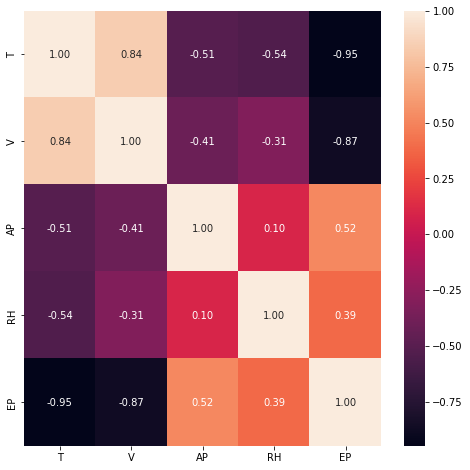

In [ ]:
import seaborn as sns
from pylab import rcParams

def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 8,8
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

# plot correlation & densities
plot_correlation(df)

In [ ]:
''' Preprocessing- standard-scaling'''
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_scaled = sc_X.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled)

sc_y = StandardScaler()
y_scaled = sc_y.fit_transform(y)
y_scaled=pd.DataFrame(y_scaled)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

X_scaled=X_scaled.values
y_scaled=y_scaled.values

In [ ]:
''' get the number of variables that gives u max adjust R sq score,
 default selector.score in linear regression = R2 '''
estimator = LinearRegression() #use regression model for regression problem
list_r2=[]
max_r2 = 0
for i in range(1,len(X_scaled[0])+1):
    selector = RFE(estimator, n_features_to_select=i, step=1)
    selector = selector.fit(X_scaled, y_scaled)
    adj_r2 = 1 - ((len(X_scaled)-1)/(len(X_scaled)-i-1))*(1-selector.score(X_scaled, y_scaled))
    list_r2.append(adj_r2)# mse = 
    if max_r2 < adj_r2:
        sel_features2 = selector.support_ # 12 features selected exactly to give max adj r2
        max_r2 = adj_r2

In [ ]:
''' optimal features to use'''        
X = X_scaled[:,sel_features2]
X = pd.DataFrame(X, columns=('T', 'V', 'AP', 'RH'))

y = pd.DataFrame(y_scaled, columns=[('EP')])

In [ ]:
'''correlation matrix between X variables'''
cor_matrix=X.astype(float).corr(method='pearson')

In [ ]:
'''split data'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3,random_state=0)

In [ ]:
# y_test = sc_X.fit_transform(y_test)
y_test

,EP
4834,-1.355612
1768,0.330772
2819,0.396985
7779,-0.496013
7065,-0.180182
...,...
9503,-0.060647
6776,0.247566
6014,-0.097562
3299,0.825320


In [ ]:
'''fit knn to the model'''
from sklearn.neighbors import KNeighborsRegressor #KNeighborsRegressor if linear regression
knn = KNeighborsRegressor()

In [ ]:
'''find the optimal parameters in KNN'''
param_dict = {
                'n_neighbors': [5,10,15],
                'weights': ['uniform', 'distance' ],
                'p' :[1, 2]          
             }

from sklearn.model_selection import GridSearchCV
knn = GridSearchCV(knn,param_dict)
knn.fit(X_train,y_train)
knn.best_params_ 
knn.best_score_

0.9505678317134706

In [ ]:
'''refit knn to the model with optimal parameters'''
knn=KNeighborsRegressor(n_neighbors= 10, p=1, weights='distance')
knn.fit(X_train,y_train)
#predictions for test
y_pred2 = knn.predict(X_test)

In [ ]:
'''R2 and adjusted R2, and rmse'''
r2=knn.score(X_test,y_test)
print(r2)
adj_r2 = 1 - ((len(X_test)-1)/(len(X_test)-i-1))*(1-knn.score(X_test, y_test))
print(adj_r2)

mse=mean_squared_error(y_test, y_pred2) #biased mean
print(mse)
rmse = math.sqrt(mse)
print(rmse)

0.9562996751462687
0.9562447924776926
0.04376283655225142
0.2091956896120267


In [ ]:
'''Cross validation'''
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import SCORERS
SCORERS.keys()

kf= KFold(n_splits=5, shuffle= True, random_state=1)
knn1= KNeighborsRegressor(n_neighbors= 10, p=1, weights='distance') 
knn1=knn1.fit(X_train, y_train)

In [ ]:
'''Cross validation score (R2 for test data, and full data)'''
r2score_2=cross_val_score(knn1,X_test,y_test, cv=kf, scoring='r2')
print(r2score_2.mean())
r2score_2b=cross_val_score(knn,X,y, cv=kf, scoring='r2')
print(r2score_2b.mean())

0.9482037043943663
0.9555866360886824


In [ ]:
'''Cross validation score (RMSE for test data, and full data)'''
RMSE_2=np.sqrt(-cross_val_score(knn1,X_test,y_test, cv=kf, scoring='neg_mean_squared_error'))
print(RMSE_2.mean())
RMSE_2b=np.sqrt(-cross_val_score(knn,X,y, cv=kf, scoring='neg_mean_squared_error'))
print(RMSE_2b.mean())

0.2274217753965401
0.21043656586093226


In [ ]:
# from sklearn import preprocessing
# lab = preprocessing.LabelEncoder()
# y_test = lab.fit_transform(y_test)
# y_pred2 = lab.fit_transform(y_pred2)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracy =cross_val_score(estimator = knn1, X = X_train, y= y_train,cv=5)
accuracy.mean()
accuracy.std()

0.004270549996010748

In [ ]:
print(accuracy)

[0.95316069 0.95405308 0.94471524 0.95351792 0.94504871]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


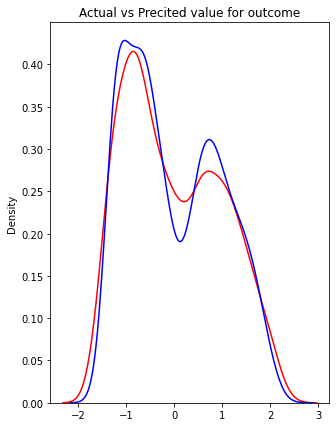

In [ ]:
import seaborn as sns
plt.figure(figsize=(5, 7))
ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred2, hist=False, color="b", label="Predicted Values", ax=ax)
plt.title('Actual vs Precited value for outcome')
plt.show()
plt.close()

In [ ]:
end=time.time()
print("Execution time=", end-start)

Execution time= 4.623552322387695


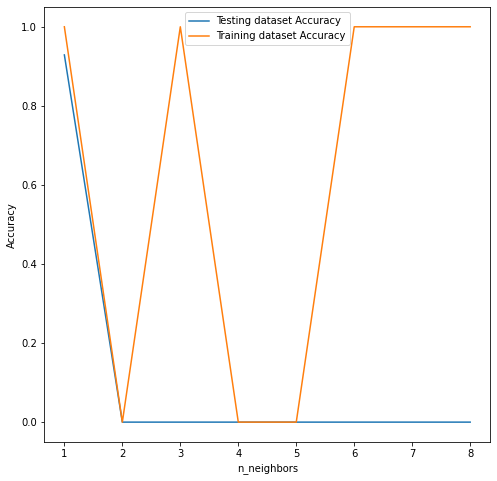

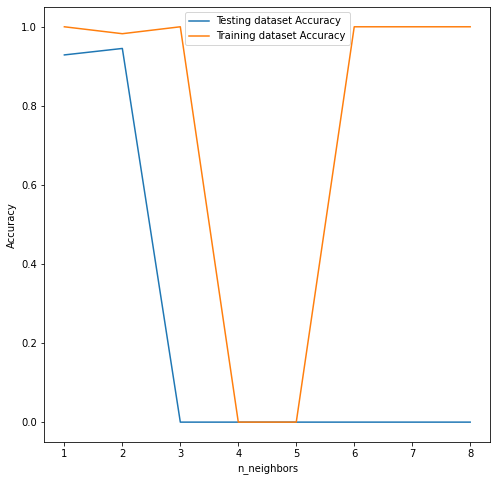

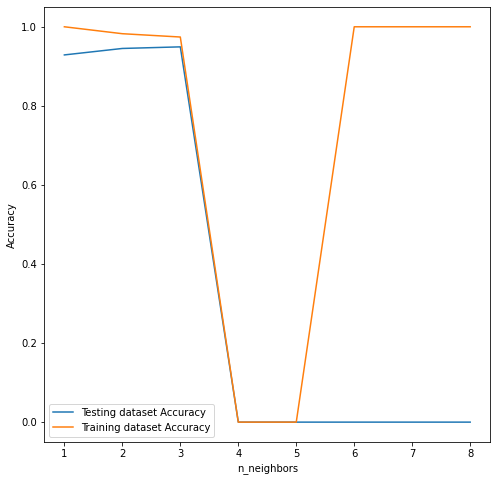

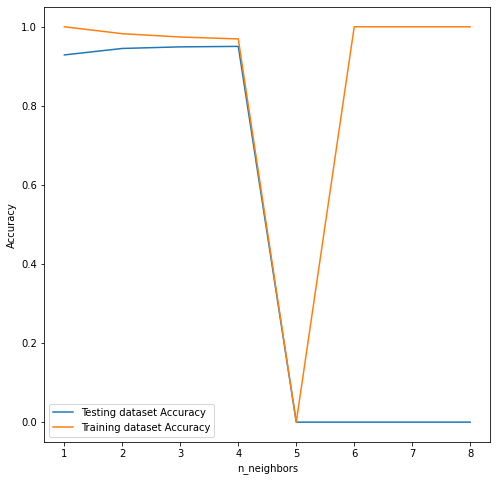

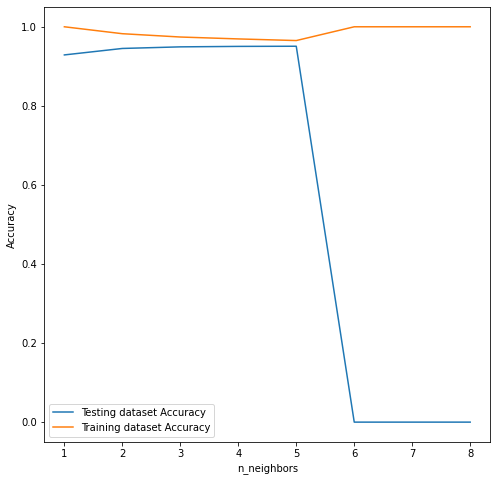

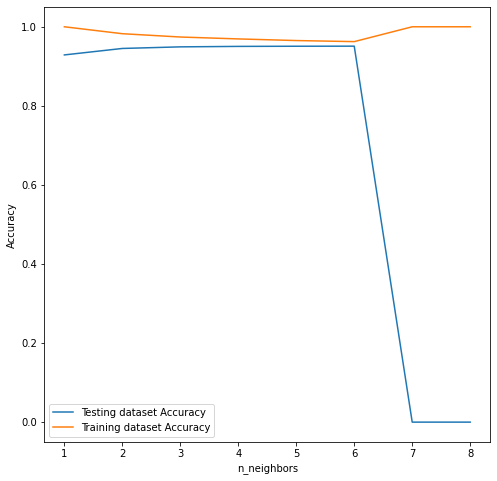

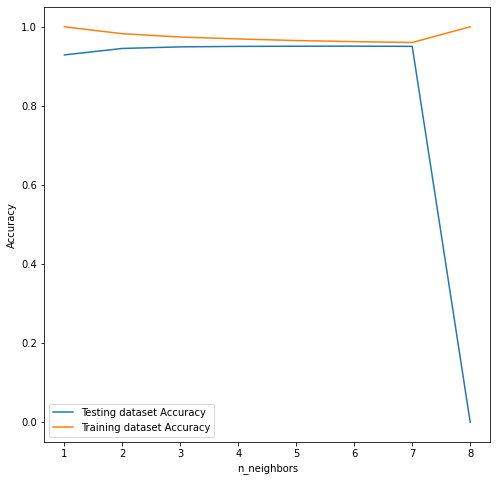

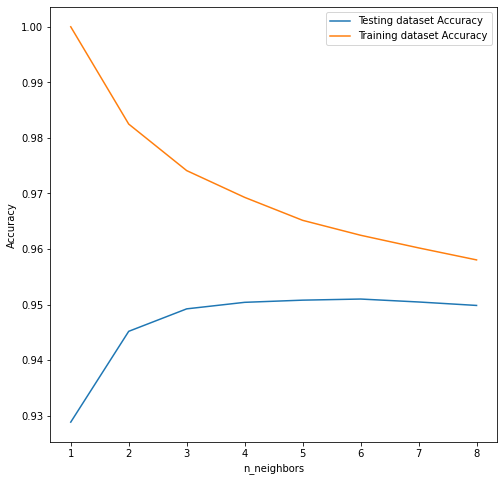

In [ ]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

    plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
from math import sqrt
k_range = range(1, 26)
mse_val = [] #to store rmse values for different k
rmse_val = [] #to store rmse values for different k
list_training_error = []
list_testing_error = []

for K in k_range:
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    y_train_pred = model.predict(X_train)
   
    mean =mean_squared_error(y_test,pred)#calculate mse
    mse_val.append(mean)
    print('MSE value for k= ' , K , 'is:', mean)

    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

    fold_training_error = mean_absolute_error(y_train, y_train_pred)     #calculate mae   
    fold_testing_error = mean_absolute_error(y_test, pred)
    list_training_error.append(fold_training_error)
    list_testing_error.append(fold_testing_error)

Text(0, 0.5, 'Testing MSE')

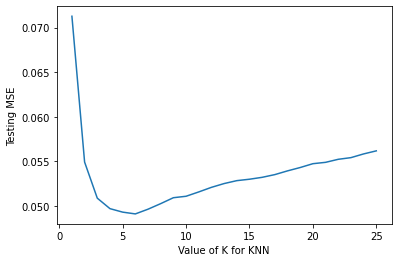

In [ ]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, mse_val)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing MSE')

Text(0, 0.5, 'Testing RMSE')

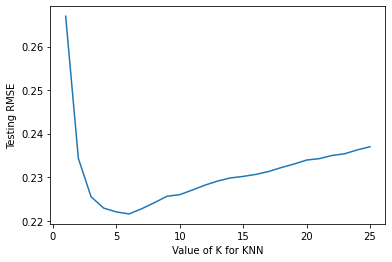

In [ ]:
#plotting the rmse values against k values
plt.plot(k_range, rmse_val)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing RMSE')

Text(0, 0.5, 'Training error')

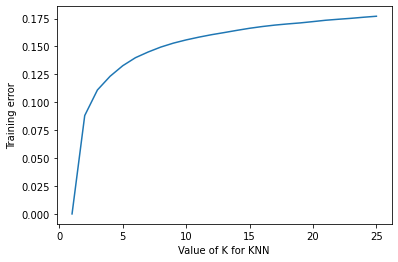

In [ ]:
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline
plt.plot(k_range, list_training_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Training error')

Text(0, 0.5, 'Testing error')

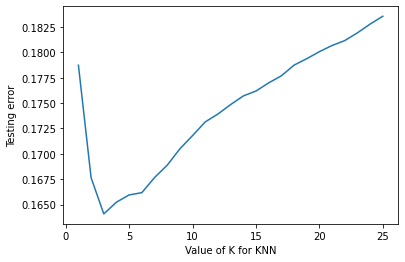

In [ ]:

plt.plot(k_range, list_testing_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing error')